## Training to advection terms

In [1]:
#imports
import jax
import jax.numpy as jnp

import jax_cfd.base as cfd
from jax_cfd.base import advection
from jax_cfd.ml import towers
import jax_cfd.ml.train_utils as train_utils
from jax_cfd.base import finite_differences as fd
from jax_cfd.base import grids

import haiku as hk
import numpy as np
import xarray
import random

import pickle
# from jax_cfd.ml.diego_model_utils import SaveObject, forward_pass_module
import jax_cfd.ml.diego_preprocessing as preprocessing
import jax_cfd.ml.diego_train_functions as training
from jax_cfd.ml import nonlinearities
import jax_cfd.ml.diego_cnn_bcs as bcs

import jax_cfd.ml.newSaveObject as saving
import jax_cfd.ml.diego_towers as mytowers

import matplotlib.pyplot as plt
import seaborn

import time

import tree_math

In [2]:
# this allows me to reload a module without having to interrupt the kernel
import importlib
importlib.reload(mytowers)
# importlib.reload(from jax_cfd.ml.diego_train_functions import *)
# importlib.reload(from jax_cfd.ml import nonlinearities)
# importlib.reload(from jax_cfd.ml.diego_cnn_bcs import *)

<module 'jax_cfd.ml.diego_towers' from '/rds/general/user/dd519/home/FYP/forked_jax/jax-cfd/jax_cfd/ml/diego_towers.py'>

In [3]:
# import data
file_name = '1080x256_150_seconds_inner_1'
data = xarray.open_dataset(f'../../creating_dataset/datasets/'+ file_name +'.nc', chunks={'time': '100MB'})

In [4]:
# split by timestamps
x_shape = len(data.x)
y_shape = len(data.y)
high_def = []
for i in range(int(len(data.time))):
    this_time = np.dstack([
        jnp.array([data.u.isel(time = i)]).reshape(x_shape,y_shape),
        jnp.array([data.v.isel(time = i)]).reshape(x_shape,y_shape)
    ])
    high_def.append(this_time)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
#warm up time (may want to discard initial stages of simulation since not really representative of turbulent flow?)
dt = float(data.time[0].values)

outer_steps = len(data.time.values)

inner_steps = (data.time[1].values-data.time[0].values)/dt

total_sim_time = outer_steps*inner_steps*dt
print("dt: \t\t" + str(dt))
print("outer_steps: \t" + str(outer_steps))
print("inner_steps: \t" + str(inner_steps))
print("total_sim_time: " + str(total_sim_time))

warm_up = 15 #seconds
warm_index = int(warm_up/total_sim_time * outer_steps // 1)
print("removed points: " + str(warm_index))
high_def = high_def[warm_index:]

print("\n")
step = 50
high_def = high_def[0::step]
print("step = " + str(step))
print("Training dataset shape: ") # (frames, x, y, input channels)
print("\t" + str(np.shape(high_def)))

dt: 		0.003703703703703704
outer_steps: 	40499
inner_steps: 	1.0
total_sim_time: 149.9962962962963
removed points: 4050


step = 50
Training dataset shape: 
	(729, 1080, 256, 2)


In [6]:
def convect(v):  # pylint: disable=function-redefined
      return tuple(
          advection.advect_van_leer(u, v, dt) for u in v)
    
convection = cfd.equations._wrap_term_as_vector(convect, name='convection')

In [7]:
dim = 5
u = np.arange(dim**2).reshape(dim,dim)
v = np.arange(dim**2).reshape(dim,dim)*0.1

velField = jnp.dstack([u,v])
np.shape(velField)

(5, 5, 2)

In [8]:
def reshapeForAdvection(v):
    mygrid = (grids.GridVariable(array = grids.GridArray(data = v[:,:,0], 
                                            offset = (1.0, 0.5), 
                                            grid=grids.Grid(
                                                shape=(1080, 256),  
                                                domain=((0.0, 8.0), (0.0, 2.0)) ) ),
#                        bc=cfd.boundaries.channel_flow_boundary_conditions(ndim=2)
                        bc = cfd.boundaries.periodic_boundary_conditions(2)
                   ),
             grids.GridVariable(array = grids.GridArray(data = v[:,:,1], 
                                            offset = (0.5, 1.0),
                                            grid=grids.Grid(
                                                shape=(1080, 256),  
                                                domain=((0.0, 8.0), (0.0, 2.0)) ) ),
#                        bc=cfd.boundaries.channel_flow_boundary_conditions(ndim=2)
                        bc = cfd.boundaries.periodic_boundary_conditions(2)
                   )
           )
    return tree_math.Vector(mygrid)

In [9]:
# diego = reshapeForAdvection(velField)
# diego

In [10]:
# flat = diego.tree_flatten()[0][0]
# u = flat[0].array.data
# v = flat[1].array.data

# flat[0].

In [11]:
all_advected = []
for field in high_def:
    advected = convection(reshapeForAdvection(field))
    vel = 0
    uadv = advected.tree_flatten()[0][0][vel].data
    vel = 1
    vadv = advected.tree_flatten()[0][0][vel].data
    this_time = jnp.dstack([
            jnp.array(uadv),
            jnp.array(vadv)
        ])
    all_advected.append(this_time)

In [12]:
#split into train and test

split = 0.8
split = int(len(high_def)*split//1)
random.shuffle(high_def)

factor = 4

print("Create X dataset: ")
%time X_dataset = preprocessing.creatingDataset(high_def,preprocessing.sampling,factor)

print("\nCreate Y dataset: ")
padding = [1,1]
%time Y_dataset = preprocessing.creatingDataset(all_advected,preprocessing.sampling,factor)

# %time Y_dataset = calculateResiduals(X_dataset,Y_dataset)


X_train = X_dataset[:split]
Y_train = Y_dataset[:split]

X_test = X_dataset[split:]
Y_test = Y_dataset[split:]



# print("\nPadding all datasets: ")
# padding = [1,1] #this is for a 3 by 3 kernel, find a better way to define this (so not redifined when creating CNN)
# %time X_train = padXDataset(X_train,padding)
# %time Y_train = padYDatasetNew(Y_train,padding,conditions)

# %time X_test = padXDataset(X_test,padding)
# %time Y_test = padYDataset(Y_test,padding,conditions)

print("\nShapes of all datasets")
training.printAllShapes(X_train,Y_train, X_test,Y_test)

Create X dataset: 
CPU times: user 549 ms, sys: 85.3 ms, total: 635 ms
Wall time: 636 ms

Create Y dataset: 
CPU times: user 1.55 s, sys: 347 ms, total: 1.9 s
Wall time: 1.4 s

Shapes of all datasets
(583, 270, 64, 2)
(583, 270, 64, 2)
(146, 270, 64, 2)
(146, 270, 64, 2)


In [13]:
def ConvNet(x):
    cnn = mytowers.CNN(CNN_specs)
    return cnn(x)

CNN_specs = {
    "hidden_channels" : 50,
    "hidden_layers" : 5,
    "nonlinearity" : "relu",
    "num_output_channels" : 2
}
input_channels = 2

# CNN_specs = None

In [14]:
forward_pass = hk.without_apply_rng(hk.transform(ConvNet))

In [ ]:
instance = training.MyTraining(X_train,Y_train,X_test,Y_test,
                      jax.random.PRNGKey(40), #rng_key
                      input_channels=2,
                      epochs = 60,
                      printEvery=1,#epochs
                      learning_rates=training.staggeredLearningRate((30,0.1),(20,0.01),(30,0.001)), #iterated over batches
                      batch_size=len(X_train)//2+1, # number or len(X_train)
                      validateEvery=1,
                      params=None,
                      forward_pass=forward_pass,
                      tol = 1e-10)

%time instance.train()

Shapes of all datasets
(583, 270, 64, 2)
(583, 270, 64, 2)
(146, 270, 64, 2)
(146, 270, 64, 2)



Start time: 15:51:15
Epoch 1/60
	mse : 0.036394		val mse : 0.087951	Estimated end time: 17:21:50


Epoch 2/60
	mse : 0.036369		val mse : 0.087934	Estimated end time: 17:44:57


Epoch 3/60
	mse : 0.036356		val mse : 0.087924	Estimated end time: 17:55:43


Epoch 4/60
	mse : 0.036347		val mse : 0.087915	Estimated end time: 18:02:37


Epoch 5/60
	mse : 0.036339		val mse : 0.087907	Estimated end time: 18:06:37


Epoch 6/60
	mse : 0.036332		val mse : 0.087899	Estimated end time: 18:09:40


Epoch 7/60
	mse : 0.036325		val mse : 0.087892	Estimated end time: 18:12:02


Epoch 8/60
	mse : 0.036319		val mse : 0.087885	Estimated end time: 18:14:30


Epoch 9/60
	mse : 0.036313		val mse : 0.087878	Estimated end time: 18:15:42


Epoch 10/60
	mse : 0.036307		val mse : 0.087871	Estimated end time: 18:17:03


Epoch 11/60
	mse : 0.036302		val mse : 0.087865	Estimated end time: 18:19:00


Epoch 12/60
	mse : 0.

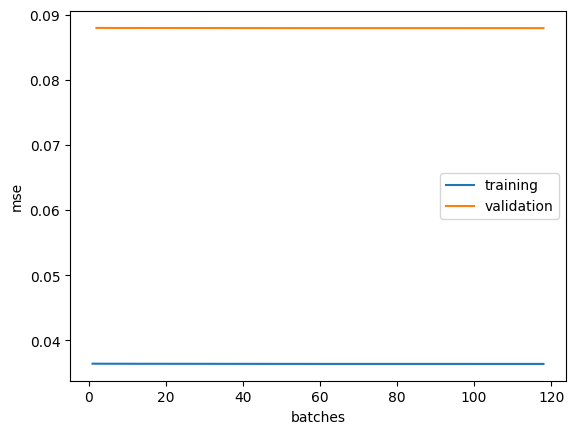

In [18]:

batches = np.arange(len(instance.losses))
val_step = len(instance.losses)//len(instance.val_losses)

batches_val = batches[::val_step]+val_step
plt.plot(batches+1,instance.losses, label="training")
plt.plot(batches_val,instance.val_losses,label="validation")
plt.ylabel("mse")
plt.xlabel("batches")
# plt.yscale("log")
plt.legend()

In [ ]:
description = "left for lunch, please save me"

In [ ]:
toSave = saving.newSaveObject(instance.params,instance.losses,instance.val_losses,description,CNN_specs)

In [2]:
save_path = "./../models/final_models/advection_direct_1080.pickle"

In [ ]:
with open(save_path,"wb") as f:
    pickle.dump(toSave,f)

del save_path

## Loading model

In [5]:
with open(save_path,'rb',) as pickle_file:
    loaded = pickle.load(pickle_file)
    CNN_specs = loaded.CNN_specs
    loaded.forward_pass = hk.without_apply_rng(hk.transform(ConvNet))

In [6]:
loaded.description

'left for lunch, please save me'

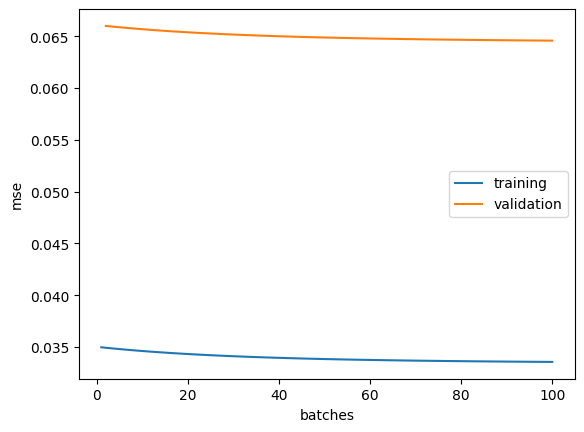

In [7]:
batches = np.arange(len(loaded.losses))
val_step = len(loaded.losses)//len(loaded.val_losses)

batches_val = batches[::val_step]+val_step
plt.plot(batches+1,loaded.losses, label="training")
plt.plot(batches_val,loaded.val_losses,label="validation")
plt.ylabel("mse")
plt.xlabel("batches")
# plt.yscale("log")
plt.legend()

<AxesSubplot: >

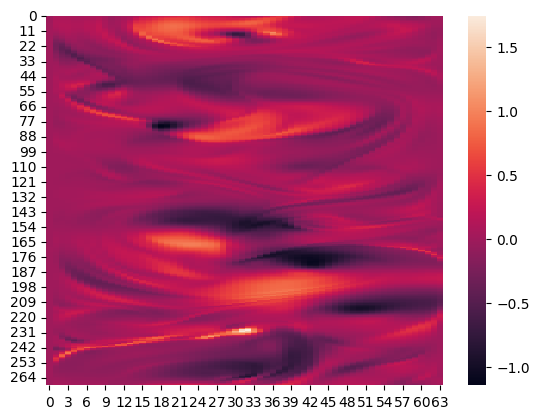

In [23]:
seaborn.heatmap(Y_dataset[-1][:,:,0])